# Super Math Saga experiment analysis

Background: Some time ago we ran an experiment (A/B Test) on the game to improve it’s performance. The experiment offered two different game experiences that we call A and B, group A being the control group where the experience is kept as is, and group B being the experiment group that is exposed to the new experience. We set the assignment process to distribute players among the two groups: 80% to group A (control) and 20% to group B (test). The experiment ran from 2017-05-04 to 2017-05-22.

After successfully conducting the test and obtaining the data, there are a few different important metrics that I would like to look at to analyse the results and a few different aspects to determine which version is better and how to quantify them:
* Acquisition: Conversion rate (from no purchase to purchase) per group 
* Player engagement: Average game rounds played per player
* Monetization: Average purchases per player
* Retention after conversion: Player behaviour after conversion

Prepare the environment for this study:

In [1]:
%load_ext google.cloud.bigquery
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from google.cloud import bigquery

In [2]:
client = bigquery.Client()

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Calculate conversion rates and confidence intervals

Conversion rate is most often used and straight-forward metric in AB testing. In this study, it's thouroughly looked at including the confidence intervals comparision and cumulative conversion rates.
Be careful that some of the players have converted before the experiment start date.

In [3]:
CONV_QUERY = """
SELECT 
    abtest_group,
    count(playerid) as abtest_entrants,
    count(
        case
        when playerid is not null 
        and conversion_date >= "2017-05-04" then 1 else null 
        end) 
        as abtest_conversions
FROM `abtest.assignment`
GROUP BY 1
"""
conversion = client.query(CONV_QUERY).to_dataframe()

In [4]:
conversion['conv_rate']=conversion.abtest_conversions/conversion.abtest_entrants

In [5]:
conversion

,abtest_group,abtest_entrants,abtest_conversions,conv_rate
0,B,2066213,8505,0.004116
1,A,8264151,32918,0.003983


From above stats we can see that the control group and experiment group amount of entrants are about 80% and 20%, respectively.  
The overall conversion rate of the B group is slightly better than A group (3% relative increase), but is this result statistically significant?
Below we will calculate the confidence intervals of the conversion rate for the two groups:

In [6]:
CI_QUERY="""
with
  abtest_conversions as (
    select
      abtest_group,
      count(distinct playerid) as abtest_entrants,
      count(
        case
        when playerid is not null 
        and conversion_date >= "2017-05-04" then 1 else null
        end) 
        as abtest_conversion
    from
      `abtest.assignment`
    group by 1
  )
  , ab_test_conversion_rates as (
    select
      abtest_group,
      abtest_entrants,
      abtest_conversion,
      abtest_conversion / abtest_entrants as conversion_rate
    from
      `abtest_conversions`
  )
  , conversion_rate_standard_error as (
    select
      abtest_group,
      abtest_entrants,
      abtest_conversion,
      conversion_rate,
      sqrt(conversion_rate * (1 - conversion_rate) / abtest_entrants) as standard_error
    from
      ab_test_conversion_rates
  )
select
  abtest_group,
  abtest_entrants,
  abtest_conversion,
  conversion_rate - standard_error * 1.96 as conversion_rate_low
  , conversion_rate
  , conversion_rate + standard_error * 1.96 as conversion_rate_high
from
  conversion_rate_standard_error
"""

In [7]:
confidence_interval = client.query(CI_QUERY).to_dataframe()

In [8]:
confidence_interval

,abtest_group,abtest_entrants,abtest_conversion,conversion_rate_low,conversion_rate,conversion_rate_high
0,B,2066213,8505,0.004030,0.004117,0.004204
1,A,8264151,32918,0.003941,0.003983,0.004026


Exciting! It's demonstrated above that although the difference between the conversion rates is not large, the conversion_rate_high of group A is actually smaller than the conversion_rate_low of group B, which means that the difference is statistically significant with 95% confidence, so that we can confidently say group B has better conversion than group A.

### Conversion rates over time

Since the assignment_date of the abtest entrants are not the same day, we would like to take a deeper look on how the cumulative conversion rate evolves over time.

In [9]:
cumul_conv_query = """
WITH abtest_conversion_over_time AS (
SELECT 
    assignment_date,
    abtest_group,
    count(distinct playerid) as abtest_entrants,
    count(case
        when playerid is not null 
        and conversion_date >= "2017-05-04" 
        then 1 else null
        end) as abtest_conversions
FROM `abtest.assignment` 
GROUP BY 1,2 
ORDER BY 1,2 asc
)

SELECT 
  assignment_date,
  abtest_group,
  sum(abtest_entrants) over(partition by abtest_group order by assignment_date rows unbounded preceding) as cumulative_entrants,
  sum(abtest_conversions) over(partition by abtest_group order by assignment_date rows unbounded preceding) as cumulative_conversions
FROM `abtest_conversion_over_time`
"""
cumulated_conversion = client.query(cumul_conv_query).to_dataframe()

In [10]:
cumulated_conversion.head()

,assignment_date,abtest_group,cumulative_entrants,cumulative_conversions
0,2017-05-04,A,6851011,5048
1,2017-05-05,A,6915408,6422
2,2017-05-06,A,7005150,8387
3,2017-05-07,A,7095445,10429
4,2017-05-08,A,7167619,11960


In [11]:
cumulated_conversion['conv_rate']=cumulated_conversion.cumulative_conversions/cumulated_conversion.cumulative_entrants

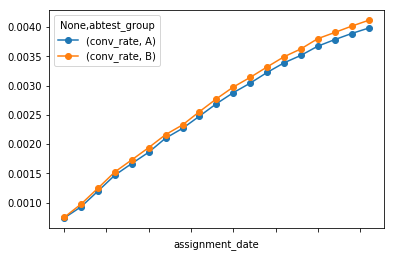

In [12]:
pd.pivot_table(cumulated_conversion, values=['conv_rate'], 
               index = ['assignment_date'], columns=['abtest_group'], aggfunc=np.sum).plot.line(style = 'o-')

In [13]:
conv_over_time_query = """
SELECT 
    assignment_date,
    abtest_group,
    count(distinct playerid) as abtest_entrants,
    count(case
        when playerid is not null 
        and conversion_date >= "2017-05-04" 
        then 1 else null
        end) as abtest_conversions
FROM `abtest.assignment` 
GROUP BY 1,2 
ORDER BY 1,2 asc

"""
conversion_over_time = client.query(conv_over_time_query).to_dataframe()

In [14]:
conversion_over_time['conversion_rate']=conversion_over_time.abtest_conversions/conversion_over_time.abtest_entrants

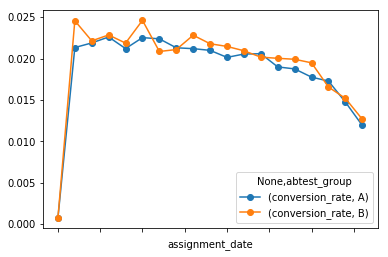

In [15]:
pd.pivot_table(conversion_over_time, values=['conversion_rate'], 
               index = ['assignment_date'], columns=['abtest_group']).plot.line(style = 'o-')

We can see that through the period, group B has a few peaks during the beginning with higher conversion rates after the experiment starts but towards the end of the experiment, group A and group B tend to converge on conversion rates.


## Game play and purchase performance: general and over time

For game performance, the average game rounds per player charicterizes the overall enjoyment/smoothness of the game, and the average purchase per player implies the monitization ability of the game. To calculate average number of game rounds and average of number of purchases per player during the period of the abtest: 

In [16]:
gameplay_query="""
SELECT 
    abtest_group,
    count(distinct an.playerid) as abtest_entrants,
    sum(gameends)/count(distinct an.playerid) as avg_game,
    sum(purchases)/count(distinct an.playerid) as avg_purchase
FROM `abtest.assignment` as an
LEFT JOIN `abtest.activity` as ac using (playerid)
WHERE activity_date >= "2017-05-04" 
GROUP BY 1 
ORDER BY 1 asc
"""
gameplay = client.query(gameplay_query).to_dataframe()

In [17]:
gameplay #average game rounds and purchases over all abtest entrants

,abtest_group,abtest_entrants,avg_game,avg_purchase
0,A,8264151,158.504712,0.370975
1,B,2066213,155.656526,0.391012


**It's shown 2% lower average game play for group B and overall 5% higher purchase rate.** However, these averages imply the mean values of the whole test period per test entrant, and some players might have played only 1 day while some played 19 days. Therefore, we can also take a look at the average game rounds/player/day and average purchase/player/day.

In [18]:
gameplay_player_day_query="""
SELECT 
    playerid,
    abtest_group,
    count(distinct activity_date) as active_days,
    sum(gameends)/count(distinct activity_date) as avg_game,
    sum(purchases)/count(distinct activity_date) as avg_purchase
FROM `abtest.assignment` as an
LEFT JOIN `abtest.activity` as ac using (playerid)
WHERE activity_date >= "2017-05-04" 
GROUP BY 1,2 
ORDER BY 1,2 asc
"""
gameplay_player_day = client.query(gameplay_player_day_query).to_dataframe()

The distributions of game play/player/day and purchase/player/day are shown as below, respectively. Both have right screwed distribution with a long tail, with the average purchase has a vast majority of people with 0 purchase, indicating a very small percentage of people making a relatively large impact:

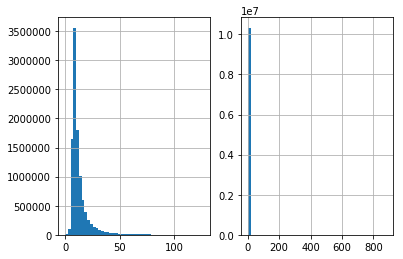

In [19]:
plt.subplot(121)
gameplay_player_day['avg_game'].hist(bins=50)
plt.subplot(122)
gameplay_player_day['avg_purchase'].hist(bins=50)

In [20]:
gameplay_desc=gameplay_player_day[['avg_game','abtest_group','avg_purchase']].groupby('abtest_group').describe()

In [21]:
gameplay_desc

avg_game                                                 \
                  count       mean       std  min       25%        50%   
abtest_group                                                             
A             8264151.0  13.179563  9.684919  0.0  8.133333  10.000000   
B             2066213.0  12.960304  9.522036  0.0  8.000000   9.933333   

                               avg_purchase                                \
                    75%    max        count      mean       std  min  25%   
abtest_group                                                                
A             14.142857  127.0    8264151.0  0.030822  0.829781  0.0  0.0   
B             14.000000  121.0    2066213.0  0.032595  0.713006  0.0  0.0   

                                    
              50%  75%         max  
abtest_group                        
A             0.0  0.0  880.642857  
B             0.0  0.0  273.230769

Since these two metrics are non-normally distributed, if we want to know wether the difference between group A and B are significant, we should use methods such as bootstraping to calculate the confidence intervals.

In [22]:
import scipy
import scikits.bootstrap as bootstrap  

*Average game rounds/player/day:*

In [23]:
CI_A = bootstrap.ci(data=gameplay_player_day[gameplay_player_day.abtest_group=='A']['avg_game'][0:100000], statfunction=scipy.mean)
CI_B = bootstrap.ci(data=gameplay_player_day[gameplay_player_day.abtest_group=='B']['avg_game'][0:100000], statfunction=scipy.mean)
print ("Bootstrapped 95% confidence intervals low and high for group A are:", CI_A[0], CI_A[1] )
print ("Bootstrapped 95% confidence intervals low and high for group A are:", CI_B[0], CI_B[1] )

Bootstrapped 95% confidence intervals low and high for group A are: 13.103303509670242 13.225036077775638
Bootstrapped 95% confidence intervals low and high for group A are: 12.866154848803756 12.98360203240662


*Average purchase/player/day*:

In [24]:
CI_A = bootstrap.ci(data=gameplay_player_day[gameplay_player_day.abtest_group=='A']['avg_purchase'][0:100000], statfunction=scipy.mean)
CI_B = bootstrap.ci(data=gameplay_player_day[gameplay_player_day.abtest_group=='B']['avg_purchase'][0:100000], statfunction=scipy.mean)
print ("Bootstrapped 95% confidence intervals low and high for group A are:", CI_A[0], CI_A[1] )
print ("Bootstrapped 95% confidence intervals low and high for group A are:", CI_B[0], CI_B[1] )

Bootstrapped 95% confidence intervals low and high for group A are: 0.026696208201499223 0.032045227443308316
Bootstrapped 95% confidence intervals low and high for group A are: 0.0272067368182643 0.03361617571515173


According to the results above, we can see that group B's average daily game play is lower with 95% confidence, however, we cannot confidently say that group B's daily average purchase is higher than group A, it could be due to variation.

Let's take a closer look at how the performance metrics per group over time **before and after the experiment starts:**

In [25]:
gameplay_overtime_query="""
SELECT 
    activity_date,
    abtest_group,
    count(distinct an.playerid) as players,
    sum(gameends)/count(distinct an.playerid) as avg_game,
    sum(purchases)/count(distinct an.playerid) as avg_purchase
FROM `abtest.assignment` as an
LEFT JOIN `abtest.activity` as ac using (playerid)
GROUP BY 1,2 
ORDER BY 1,2 asc
"""
perform_over_time = client.query(gameplay_overtime_query).to_dataframe()

**Average game rounds/player by day**: 
We can see that after the experiment starts (2017-05-04), group B (Experiment group) has been dropping in avg game rounds since the experiment starts, while the control group has stayed stable, which is a indication of the treatment has lowered the engagement due to some factor, e.g. game difficulty increased or waiting time increased etc.

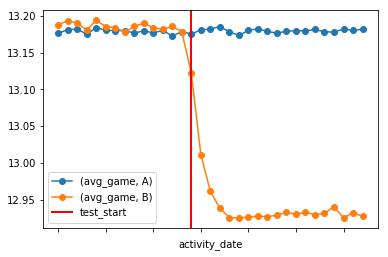

In [26]:
fig, ax = plt.subplots()
pd.pivot_table(perform_over_time, values=['avg_game'], 
               index = ['activity_date'], columns=['abtest_group']).plot.line(style = 'o-', ax=ax)
ax.axvline(x=14 , color='red', linewidth=2, label='test_start')
ax.legend(loc='lower left')

**Average purchases/player by day**: 
If we look at the average purchase performance during this experiment period, we can see that after the experiment starts, the purchases peaked for group B while group A remains relatively stable. However, at the end of the study, the purchase rate decreased to normal/group A level.

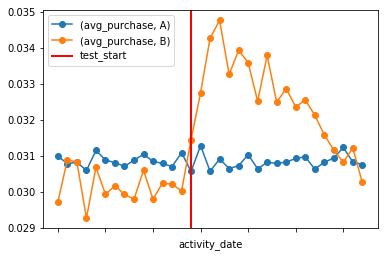

In [27]:
fig, ax = plt.subplots()
pd.pivot_table(perform_over_time, values=['avg_purchase'], 
               index = ['activity_date'], columns=['abtest_group']).plot.line(style = 'o-', ax=ax)
ax.axvline(x=14 , color='red', linewidth=2, label='test_start')
ax.legend(loc='upper left')

## Retention Analysis

It seems that the average purchases have been higher and it's confirmed that we have more conversions in Group B during the experiment, however, the average number of game rounds has dropped and the average of purchases have peaked and dropped again we would like to take a closer look at the retention of the players after the experiment? 
* Did the players churn faster after they have converted during the experiment? 

* The method: to look at the activity data e.g. game rounds and purchases after a player has converted by day, compare the test group with the control group. 

In [28]:
retention_query="""
with retention as (
SELECT
conversion_date,
date_diff(PARSE_DATE('%F', activity_date),PARSE_DATE('%F', conversion_date),day) as day_after_conv,
abtest_group,
count(distinct an.playerid) as abtest_converters,
sum(gameends)/count(distinct an.playerid) as avg_game,
sum(purchases)/count(distinct an.playerid) as avg_purchase
FROM `abtest.assignment` as an
INNER JOIN `abtest.activity` as ac using (playerid)
WHERE conversion_date >= "2017-05-04" and activity_date >= conversion_date
GROUP BY 1,2,3
ORDER BY 1,2,3 asc
)

select 
day_after_conv, 
abtest_group,
avg(avg_game) as avg_game_per_day,
avg(avg_purchase) as avg_purchase_per_day
from `retention`
group by 1,2
order by 1,2 asc
"""
retention_by_day = client.query(retention_query).to_dataframe()

As shown below are how players behave after aquisition(purchase), we can see that all players tend to play and purchase more on the same day of conversion. Afterwards, both game play rate and purchase rate drop significantly. For purchase rate, group B is significantly higher at the begining but it demonstrates a downwards trend while group A is relatively stable. For gameplay rate, group B shows a lot more volatility after the first day of conversion while group A is rather stable.

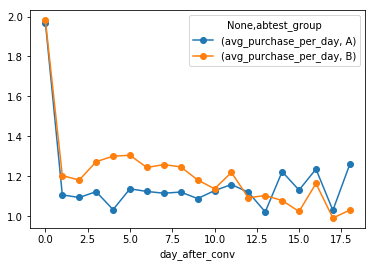

In [29]:
pd.pivot_table(retention_by_day, values=['avg_purchase_per_day'], 
               index = ['day_after_conv'], columns=['abtest_group']).plot.line(style = 'o-')

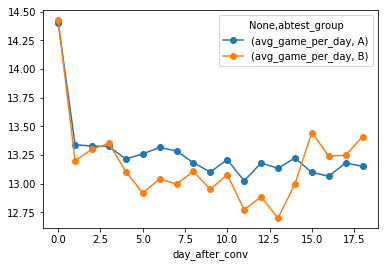

In [30]:
pd.pivot_table(retention_by_day, values=['avg_game_per_day'], 
               index = ['day_after_conv'], columns=['abtest_group']).plot.line(style = 'o-')

## Conclusion

By analysing a few KPIs such as conversion rate, average game rounds and average purchases in the test results, we can conclude the following points:

* The treatment increased the conversion of purchase, but increase is concentrated on the beginning of the experiment period
* The treatment has an effect of decreasing the average game rounds played 
* The treatment increased the overall average number of purchases during the period of abtest
* Although the abtest cannot determine any long term effect, the treatment MIGHT affect user retention negatively.

The overall test is successful since the treatment did confidently increse the conversion rate. However, the new treatment will lower customer engagement e.g. average game rounds/player/day, and the increase of purchases seems to be concentrated in the begining of the abtest, which indicates that the treatment might not have a longer term effect on player purchase behaviour. For further investigation, we may want to monitor group B for a bit longer time and study player loyalty and player behavior after conversion. 

The introduced treatment might be:
* Increase of difficulty so that players get more frustrated and played less and bought more boosters/lives
* Increase of waiting time before getting new lives, or getting less lives per time, since players are playing less frequently, while some are buying more lives.